# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [50]:
# can comment out after executing
# !unzip processed-celeba-small.zip

In [3]:
!ls

assets			    problem_unittests.py
dlnd_face_generation.ipynb  processed-celeba-small.zip


In [5]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [6]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [14]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    transform =  transforms.Compose([
                    transforms.Resize( (image_size, image_size) ),
                    transforms.ToTensor()
                 ])
    
    # TODO: Implement function and return a dataloader
    
    folder = datasets.ImageFolder(data_dir, transform)
    
    data_loader = torch.utils.data.DataLoader(dataset=folder,
                                          batch_size=batch_size,
                                          shuffle=True)
    
    return data_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [19]:
# Define function hyperparameters
batch_size = 64
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

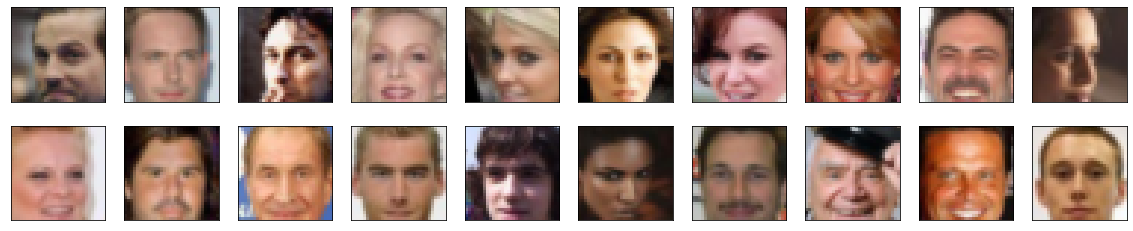

In [20]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [21]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    
    min, max = feature_range
    x = x * (max - min) + min
    
    return x


In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.8510)
Max:  tensor(0.6863)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [26]:
import torch.nn as nn
import torch.nn.functional as F

def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
     
    return nn.Sequential(*layers)


def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                   kernel_size, stride, padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
     
    return nn.Sequential(*layers)

In [27]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        
        self.conv_dim = conv_dim

        # complete init function
        
        self.c1 = conv(3, conv_dim, 4, batch_norm=False) # 16x16, 32
        self.c2 = conv(conv_dim, conv_dim*2, 4) # 8x8, 64
        self.c3 = conv(conv_dim*2, conv_dim*4, 4) # 4x4, 128

        self.f1 = nn.Linear(conv_dim*4*4*4, 1)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        
        x = F.leaky_relu(self.c1(x), 0.2)
        x = F.leaky_relu(self.c2(x), 0.2)
        x = F.leaky_relu(self.c3(x), 0.2)
        
        x = x.view(-1, self.conv_dim*4*4*4)
        
        x = self.f1(x)
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [30]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        self.conv_dim = conv_dim
        
        self.fc1 = nn.Linear(z_size, conv_dim*4*4*4)
        
        # complete init function
        self.dc1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.dc2 = deconv(conv_dim*2, conv_dim, 4)
        self.dc3 = deconv(conv_dim, 3, 4,  batch_norm=False)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        
        x = self.fc1(x)
        x = x.view(-1, self.conv_dim*4, 4, 4)
        
        x = F.relu(self.dc1(x))
        x = F.relu(self.dc2(x))
        x = F.tanh(self.dc3(x))
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


/home/max/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [34]:
from torch.nn import init

def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    init_gain = 0.02
    
    # TODO: Apply initial weights to convolutional and linear layers
    
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.normal_(m.weight.data, 0.0, init_gain)
       
        if hasattr(m, 'bias') and m.bias is not None:
            init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm2d') != -1:
        init.normal_(m.weight.data, 1.0, init_gain)
        init.constant_(m.bias.data, 0.0)
    
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [35]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [36]:
# Define model hyperparams
d_conv_dim = 32 
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (c1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (c2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (c3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (f1): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc1): Linear(in_features=100, out_features=2048, bias=True)
  (dc1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dc2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1):

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [37]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [42]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    
    batch_size = D_out.size(0)
    
    labels = torch.ones(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss


def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()

    loss = criterion(D_out.squeeze(), labels)
    
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [39]:
import torch.optim as optim

lr = 0.0002
beta1= 0.5
beta2= 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [43]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            
            if train_on_gpu:
                real_images = real_images.cuda()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)

            g_loss.backward()
            g_optimizer.step()

            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [45]:
# set number of epochs 
n_epochs = 100


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/  100] | d_loss: 0.9193 | g_loss: 1.3507
Epoch [    1/  100] | d_loss: 1.0993 | g_loss: 1.1448
Epoch [    1/  100] | d_loss: 1.1033 | g_loss: 0.9378
Epoch [    1/  100] | d_loss: 1.0823 | g_loss: 0.8690
Epoch [    1/  100] | d_loss: 0.9203 | g_loss: 1.3906
Epoch [    1/  100] | d_loss: 1.0998 | g_loss: 0.8495
Epoch [    1/  100] | d_loss: 1.1322 | g_loss: 0.8475
Epoch [    1/  100] | d_loss: 1.1391 | g_loss: 1.7900
Epoch [    1/  100] | d_loss: 1.1670 | g_loss: 1.9129
Epoch [    1/  100] | d_loss: 1.0709 | g_loss: 1.2844
Epoch [    1/  100] | d_loss: 1.1281 | g_loss: 1.2775
Epoch [    1/  100] | d_loss: 1.1259 | g_loss: 0.8337
Epoch [    1/  100] | d_loss: 1.2507 | g_loss: 1.7034
Epoch [    1/  100] | d_loss: 1.1187 | g_loss: 1.2267
Epoch [    1/  100] | d_loss: 1.2664 | g_loss: 1.0277
Epoch [    1/  100] | d_loss: 0.9109 | g_loss: 1.4962
Epoch [    1/  100] | d_loss: 0.8892 | g_loss: 1.4081
Epoch [    1/  100] | d_loss: 1.3032 | g_loss: 0.9151
Epoch [    1/  100] | d_loss

Epoch [    6/  100] | d_loss: 0.9160 | g_loss: 1.9170
Epoch [    6/  100] | d_loss: 0.8505 | g_loss: 1.0783
Epoch [    6/  100] | d_loss: 1.0651 | g_loss: 2.2466
Epoch [    6/  100] | d_loss: 0.9421 | g_loss: 0.7931
Epoch [    6/  100] | d_loss: 0.9399 | g_loss: 1.2033
Epoch [    6/  100] | d_loss: 0.8484 | g_loss: 1.6363
Epoch [    6/  100] | d_loss: 0.7962 | g_loss: 1.9318
Epoch [    6/  100] | d_loss: 0.6511 | g_loss: 1.4407
Epoch [    6/  100] | d_loss: 0.7438 | g_loss: 1.8918
Epoch [    6/  100] | d_loss: 1.2827 | g_loss: 0.7548
Epoch [    6/  100] | d_loss: 0.8641 | g_loss: 0.9733
Epoch [    6/  100] | d_loss: 1.9352 | g_loss: 3.3568
Epoch [    6/  100] | d_loss: 0.6973 | g_loss: 2.2515
Epoch [    6/  100] | d_loss: 0.7234 | g_loss: 1.7343
Epoch [    6/  100] | d_loss: 0.6242 | g_loss: 2.0362
Epoch [    6/  100] | d_loss: 0.5994 | g_loss: 1.7707
Epoch [    6/  100] | d_loss: 0.7183 | g_loss: 1.7174
Epoch [    6/  100] | d_loss: 0.6033 | g_loss: 1.6173
Epoch [    6/  100] | d_loss

Epoch [   11/  100] | d_loss: 0.4408 | g_loss: 2.5047
Epoch [   11/  100] | d_loss: 0.4589 | g_loss: 2.6428
Epoch [   11/  100] | d_loss: 0.6233 | g_loss: 3.1537
Epoch [   11/  100] | d_loss: 0.4562 | g_loss: 2.2097
Epoch [   11/  100] | d_loss: 0.5292 | g_loss: 2.8796
Epoch [   11/  100] | d_loss: 1.1394 | g_loss: 0.7103
Epoch [   11/  100] | d_loss: 0.6386 | g_loss: 2.4322
Epoch [   11/  100] | d_loss: 0.2883 | g_loss: 2.6148
Epoch [   11/  100] | d_loss: 0.5293 | g_loss: 2.6792
Epoch [   11/  100] | d_loss: 0.9598 | g_loss: 1.0429
Epoch [   11/  100] | d_loss: 0.4203 | g_loss: 1.9485
Epoch [   11/  100] | d_loss: 0.6161 | g_loss: 2.2455
Epoch [   11/  100] | d_loss: 0.5147 | g_loss: 1.7755
Epoch [   11/  100] | d_loss: 0.5446 | g_loss: 2.9090
Epoch [   11/  100] | d_loss: 0.4254 | g_loss: 2.6205
Epoch [   12/  100] | d_loss: 0.5824 | g_loss: 2.4946
Epoch [   12/  100] | d_loss: 0.6913 | g_loss: 0.4953
Epoch [   12/  100] | d_loss: 0.4005 | g_loss: 2.0967
Epoch [   12/  100] | d_loss

Epoch [   16/  100] | d_loss: 0.4478 | g_loss: 2.1009
Epoch [   16/  100] | d_loss: 0.9424 | g_loss: 4.5227
Epoch [   16/  100] | d_loss: 0.2970 | g_loss: 3.6830
Epoch [   16/  100] | d_loss: 0.2858 | g_loss: 2.8865
Epoch [   16/  100] | d_loss: 0.3623 | g_loss: 1.9224
Epoch [   16/  100] | d_loss: 0.4037 | g_loss: 2.9120
Epoch [   16/  100] | d_loss: 0.5152 | g_loss: 3.3951
Epoch [   16/  100] | d_loss: 0.2372 | g_loss: 2.4466
Epoch [   17/  100] | d_loss: 0.4905 | g_loss: 2.4705
Epoch [   17/  100] | d_loss: 0.2145 | g_loss: 3.1638
Epoch [   17/  100] | d_loss: 0.3046 | g_loss: 2.9862
Epoch [   17/  100] | d_loss: 0.2149 | g_loss: 3.3263
Epoch [   17/  100] | d_loss: 5.4305 | g_loss: 4.3245
Epoch [   17/  100] | d_loss: 0.1927 | g_loss: 3.1526
Epoch [   17/  100] | d_loss: 0.3607 | g_loss: 2.9813
Epoch [   17/  100] | d_loss: 1.5308 | g_loss: 4.3750
Epoch [   17/  100] | d_loss: 0.3072 | g_loss: 3.0695
Epoch [   17/  100] | d_loss: 0.3627 | g_loss: 2.3199
Epoch [   17/  100] | d_loss

Epoch [   21/  100] | d_loss: 0.2908 | g_loss: 4.6626
Epoch [   22/  100] | d_loss: 0.8125 | g_loss: 5.2010
Epoch [   22/  100] | d_loss: 0.1690 | g_loss: 4.0011
Epoch [   22/  100] | d_loss: 0.2824 | g_loss: 3.6437
Epoch [   22/  100] | d_loss: 0.2167 | g_loss: 3.0479
Epoch [   22/  100] | d_loss: 0.3889 | g_loss: 1.8764
Epoch [   22/  100] | d_loss: 0.1960 | g_loss: 3.1197
Epoch [   22/  100] | d_loss: 0.1143 | g_loss: 2.8595
Epoch [   22/  100] | d_loss: 0.2525 | g_loss: 3.3543
Epoch [   22/  100] | d_loss: 0.2210 | g_loss: 4.0402
Epoch [   22/  100] | d_loss: 0.2241 | g_loss: 1.8270
Epoch [   22/  100] | d_loss: 1.3818 | g_loss: 1.0103
Epoch [   22/  100] | d_loss: 0.3372 | g_loss: 3.7301
Epoch [   22/  100] | d_loss: 0.2147 | g_loss: 3.2542
Epoch [   22/  100] | d_loss: 0.5258 | g_loss: 1.3942
Epoch [   22/  100] | d_loss: 0.2005 | g_loss: 2.8658
Epoch [   22/  100] | d_loss: 0.4979 | g_loss: 1.9080
Epoch [   22/  100] | d_loss: 0.2406 | g_loss: 3.2329
Epoch [   22/  100] | d_loss

Epoch [   27/  100] | d_loss: 0.1457 | g_loss: 3.3519
Epoch [   27/  100] | d_loss: 0.1942 | g_loss: 3.5943
Epoch [   27/  100] | d_loss: 0.2310 | g_loss: 4.3801
Epoch [   27/  100] | d_loss: 0.2131 | g_loss: 4.5431
Epoch [   27/  100] | d_loss: 0.2089 | g_loss: 4.3448
Epoch [   27/  100] | d_loss: 0.1436 | g_loss: 3.4784
Epoch [   27/  100] | d_loss: 0.1127 | g_loss: 3.9106
Epoch [   27/  100] | d_loss: 0.2686 | g_loss: 2.8051
Epoch [   27/  100] | d_loss: 0.1850 | g_loss: 2.9017
Epoch [   27/  100] | d_loss: 0.1218 | g_loss: 3.3778
Epoch [   27/  100] | d_loss: 0.1935 | g_loss: 4.1290
Epoch [   27/  100] | d_loss: 0.8580 | g_loss: 0.7813
Epoch [   27/  100] | d_loss: 0.2212 | g_loss: 3.8061
Epoch [   27/  100] | d_loss: 0.2170 | g_loss: 3.3550
Epoch [   27/  100] | d_loss: 0.1487 | g_loss: 4.0997
Epoch [   27/  100] | d_loss: 0.1831 | g_loss: 3.7545
Epoch [   27/  100] | d_loss: 0.2683 | g_loss: 2.7018
Epoch [   27/  100] | d_loss: 0.1703 | g_loss: 4.0995
Epoch [   27/  100] | d_loss

Epoch [   32/  100] | d_loss: 0.1060 | g_loss: 3.8792
Epoch [   32/  100] | d_loss: 1.1651 | g_loss: 1.5230
Epoch [   32/  100] | d_loss: 0.2028 | g_loss: 2.9950
Epoch [   32/  100] | d_loss: 0.1180 | g_loss: 4.4882
Epoch [   32/  100] | d_loss: 0.1156 | g_loss: 4.2309
Epoch [   32/  100] | d_loss: 0.0420 | g_loss: 4.4711
Epoch [   32/  100] | d_loss: 0.1827 | g_loss: 3.2638
Epoch [   32/  100] | d_loss: 0.1131 | g_loss: 4.0919
Epoch [   32/  100] | d_loss: 0.1799 | g_loss: 4.7017
Epoch [   32/  100] | d_loss: 0.1186 | g_loss: 3.8823
Epoch [   32/  100] | d_loss: 0.1724 | g_loss: 3.8675
Epoch [   32/  100] | d_loss: 0.1113 | g_loss: 4.7635
Epoch [   32/  100] | d_loss: 0.1490 | g_loss: 4.6254
Epoch [   32/  100] | d_loss: 0.1077 | g_loss: 3.9923
Epoch [   32/  100] | d_loss: 0.0781 | g_loss: 4.5215
Epoch [   32/  100] | d_loss: 0.3216 | g_loss: 1.8885
Epoch [   33/  100] | d_loss: 0.2503 | g_loss: 5.0893
Epoch [   33/  100] | d_loss: 0.1730 | g_loss: 5.1065
Epoch [   33/  100] | d_loss

Epoch [   37/  100] | d_loss: 0.1382 | g_loss: 3.8536
Epoch [   37/  100] | d_loss: 0.2039 | g_loss: 2.8694
Epoch [   37/  100] | d_loss: 0.0939 | g_loss: 5.9628
Epoch [   37/  100] | d_loss: 0.0740 | g_loss: 4.4330
Epoch [   37/  100] | d_loss: 0.5824 | g_loss: 2.3939
Epoch [   37/  100] | d_loss: 0.2481 | g_loss: 4.6148
Epoch [   37/  100] | d_loss: 0.1507 | g_loss: 4.3103
Epoch [   37/  100] | d_loss: 0.1028 | g_loss: 3.4395
Epoch [   37/  100] | d_loss: 0.0882 | g_loss: 4.9543
Epoch [   38/  100] | d_loss: 0.2747 | g_loss: 3.6892
Epoch [   38/  100] | d_loss: 0.0929 | g_loss: 4.0580
Epoch [   38/  100] | d_loss: 0.0496 | g_loss: 5.0227
Epoch [   38/  100] | d_loss: 0.0896 | g_loss: 2.9551
Epoch [   38/  100] | d_loss: 0.5132 | g_loss: 0.7020
Epoch [   38/  100] | d_loss: 0.3054 | g_loss: 4.5191
Epoch [   38/  100] | d_loss: 0.1886 | g_loss: 3.8975
Epoch [   38/  100] | d_loss: 0.0683 | g_loss: 3.9556
Epoch [   38/  100] | d_loss: 0.2023 | g_loss: 2.6879
Epoch [   38/  100] | d_loss

Epoch [   42/  100] | d_loss: 0.1303 | g_loss: 5.0393
Epoch [   42/  100] | d_loss: 1.7736 | g_loss: 3.4326
Epoch [   43/  100] | d_loss: 0.6412 | g_loss: 2.1554
Epoch [   43/  100] | d_loss: 0.1139 | g_loss: 3.3354
Epoch [   43/  100] | d_loss: 0.0867 | g_loss: 4.9272
Epoch [   43/  100] | d_loss: 0.1312 | g_loss: 5.0098
Epoch [   43/  100] | d_loss: 0.2096 | g_loss: 4.2017
Epoch [   43/  100] | d_loss: 0.0424 | g_loss: 4.0243
Epoch [   43/  100] | d_loss: 0.3757 | g_loss: 4.8084
Epoch [   43/  100] | d_loss: 0.1914 | g_loss: 3.0691
Epoch [   43/  100] | d_loss: 0.2374 | g_loss: 4.4592
Epoch [   43/  100] | d_loss: 0.0780 | g_loss: 4.3054
Epoch [   43/  100] | d_loss: 0.0682 | g_loss: 5.3034
Epoch [   43/  100] | d_loss: 0.0599 | g_loss: 4.1194
Epoch [   43/  100] | d_loss: 0.0989 | g_loss: 4.5999
Epoch [   43/  100] | d_loss: 0.0971 | g_loss: 4.7565
Epoch [   43/  100] | d_loss: 0.7459 | g_loss: 2.1567
Epoch [   43/  100] | d_loss: 0.1415 | g_loss: 4.0653
Epoch [   43/  100] | d_loss

Epoch [   48/  100] | d_loss: 0.1783 | g_loss: 4.3223
Epoch [   48/  100] | d_loss: 0.2848 | g_loss: 7.4487
Epoch [   48/  100] | d_loss: 0.0495 | g_loss: 4.3895
Epoch [   48/  100] | d_loss: 0.0414 | g_loss: 4.2850
Epoch [   48/  100] | d_loss: 0.1234 | g_loss: 4.6600
Epoch [   48/  100] | d_loss: 0.0222 | g_loss: 5.2107
Epoch [   48/  100] | d_loss: 0.1221 | g_loss: 4.7149
Epoch [   48/  100] | d_loss: 0.2688 | g_loss: 6.0854
Epoch [   48/  100] | d_loss: 0.1130 | g_loss: 4.5685
Epoch [   48/  100] | d_loss: 0.0633 | g_loss: 5.2163
Epoch [   48/  100] | d_loss: 0.2481 | g_loss: 4.7385
Epoch [   48/  100] | d_loss: 0.2008 | g_loss: 3.8060
Epoch [   48/  100] | d_loss: 0.0598 | g_loss: 4.9798
Epoch [   48/  100] | d_loss: 0.0691 | g_loss: 4.5140
Epoch [   48/  100] | d_loss: 0.1766 | g_loss: 5.3086
Epoch [   48/  100] | d_loss: 0.0805 | g_loss: 3.8509
Epoch [   48/  100] | d_loss: 0.1110 | g_loss: 6.1188
Epoch [   48/  100] | d_loss: 0.0399 | g_loss: 5.3396
Epoch [   48/  100] | d_loss

Epoch [   53/  100] | d_loss: 0.1419 | g_loss: 5.4967
Epoch [   53/  100] | d_loss: 0.0653 | g_loss: 5.5156
Epoch [   53/  100] | d_loss: 0.6789 | g_loss: 4.3918
Epoch [   53/  100] | d_loss: 0.1631 | g_loss: 4.2198
Epoch [   53/  100] | d_loss: 0.0224 | g_loss: 5.3401
Epoch [   53/  100] | d_loss: 0.0502 | g_loss: 4.8362
Epoch [   53/  100] | d_loss: 0.1793 | g_loss: 4.8906
Epoch [   53/  100] | d_loss: 0.0438 | g_loss: 5.5428
Epoch [   53/  100] | d_loss: 0.1097 | g_loss: 5.1640
Epoch [   53/  100] | d_loss: 1.6368 | g_loss: 2.3663
Epoch [   53/  100] | d_loss: 0.0919 | g_loss: 4.9874
Epoch [   53/  100] | d_loss: 0.0798 | g_loss: 4.9283
Epoch [   53/  100] | d_loss: 0.0582 | g_loss: 4.5324
Epoch [   53/  100] | d_loss: 0.0422 | g_loss: 6.1083
Epoch [   53/  100] | d_loss: 0.1050 | g_loss: 4.8719
Epoch [   53/  100] | d_loss: 0.0962 | g_loss: 4.9243
Epoch [   53/  100] | d_loss: 0.0718 | g_loss: 5.6499
Epoch [   54/  100] | d_loss: 0.6647 | g_loss: 8.8495
Epoch [   54/  100] | d_loss

Epoch [   58/  100] | d_loss: 0.3892 | g_loss: 4.5794
Epoch [   58/  100] | d_loss: 0.1143 | g_loss: 5.2513
Epoch [   58/  100] | d_loss: 0.0820 | g_loss: 4.9709
Epoch [   58/  100] | d_loss: 0.0411 | g_loss: 5.0512
Epoch [   58/  100] | d_loss: 0.1250 | g_loss: 4.9997
Epoch [   58/  100] | d_loss: 0.1370 | g_loss: 3.9834
Epoch [   58/  100] | d_loss: 0.0432 | g_loss: 4.6401
Epoch [   58/  100] | d_loss: 0.9501 | g_loss: 4.0781
Epoch [   58/  100] | d_loss: 0.3073 | g_loss: 4.6478
Epoch [   58/  100] | d_loss: 0.0984 | g_loss: 5.8008
Epoch [   59/  100] | d_loss: 0.0769 | g_loss: 4.4540
Epoch [   59/  100] | d_loss: 0.1319 | g_loss: 2.8745
Epoch [   59/  100] | d_loss: 0.1873 | g_loss: 3.6629
Epoch [   59/  100] | d_loss: 0.0358 | g_loss: 5.4266
Epoch [   59/  100] | d_loss: 0.1554 | g_loss: 2.6650
Epoch [   59/  100] | d_loss: 0.1731 | g_loss: 3.4600
Epoch [   59/  100] | d_loss: 0.0666 | g_loss: 5.0040
Epoch [   59/  100] | d_loss: 0.0188 | g_loss: 5.9395
Epoch [   59/  100] | d_loss

Epoch [   63/  100] | d_loss: 0.0554 | g_loss: 6.3092
Epoch [   63/  100] | d_loss: 0.0674 | g_loss: 4.7786
Epoch [   63/  100] | d_loss: 0.1147 | g_loss: 4.6729
Epoch [   64/  100] | d_loss: 0.4667 | g_loss: 7.8951
Epoch [   64/  100] | d_loss: 0.0373 | g_loss: 4.0410
Epoch [   64/  100] | d_loss: 0.0395 | g_loss: 5.6172
Epoch [   64/  100] | d_loss: 0.0284 | g_loss: 7.3908
Epoch [   64/  100] | d_loss: 0.0339 | g_loss: 5.6582
Epoch [   64/  100] | d_loss: 0.0553 | g_loss: 5.5393
Epoch [   64/  100] | d_loss: 0.0343 | g_loss: 6.1059
Epoch [   64/  100] | d_loss: 0.0514 | g_loss: 5.3992
Epoch [   64/  100] | d_loss: 0.0706 | g_loss: 5.4542
Epoch [   64/  100] | d_loss: 0.1710 | g_loss: 7.0710
Epoch [   64/  100] | d_loss: 0.0459 | g_loss: 4.6419
Epoch [   64/  100] | d_loss: 0.1600 | g_loss: 4.7350
Epoch [   64/  100] | d_loss: 0.0462 | g_loss: 6.7230
Epoch [   64/  100] | d_loss: 0.0847 | g_loss: 6.7728
Epoch [   64/  100] | d_loss: 0.0211 | g_loss: 6.6812
Epoch [   64/  100] | d_loss

Epoch [   69/  100] | d_loss: 0.0425 | g_loss: 6.5603
Epoch [   69/  100] | d_loss: 0.1059 | g_loss: 5.3609
Epoch [   69/  100] | d_loss: 0.0409 | g_loss: 3.8006
Epoch [   69/  100] | d_loss: 0.0484 | g_loss: 5.0186
Epoch [   69/  100] | d_loss: 0.0287 | g_loss: 5.7888
Epoch [   69/  100] | d_loss: 0.0622 | g_loss: 3.9652
Epoch [   69/  100] | d_loss: 0.0503 | g_loss: 6.0155
Epoch [   69/  100] | d_loss: 0.0558 | g_loss: 5.5593
Epoch [   69/  100] | d_loss: 0.0178 | g_loss: 5.6401
Epoch [   69/  100] | d_loss: 0.0207 | g_loss: 7.0956
Epoch [   69/  100] | d_loss: 0.1640 | g_loss: 6.8708
Epoch [   69/  100] | d_loss: 0.0260 | g_loss: 5.6295
Epoch [   69/  100] | d_loss: 0.0135 | g_loss: 4.7133
Epoch [   69/  100] | d_loss: 0.1603 | g_loss: 5.0873
Epoch [   69/  100] | d_loss: 0.3966 | g_loss: 4.3692
Epoch [   69/  100] | d_loss: 0.2813 | g_loss: 6.2846
Epoch [   69/  100] | d_loss: 0.0817 | g_loss: 5.4549
Epoch [   69/  100] | d_loss: 0.0252 | g_loss: 6.7573
Epoch [   69/  100] | d_loss

Epoch [   74/  100] | d_loss: 0.1065 | g_loss: 4.5702
Epoch [   74/  100] | d_loss: 0.0150 | g_loss: 6.1888
Epoch [   74/  100] | d_loss: 0.1056 | g_loss: 3.8043
Epoch [   74/  100] | d_loss: 0.0518 | g_loss: 4.9514
Epoch [   74/  100] | d_loss: 0.0362 | g_loss: 6.0097
Epoch [   74/  100] | d_loss: 0.0692 | g_loss: 6.2593
Epoch [   74/  100] | d_loss: 0.0680 | g_loss: 6.2605
Epoch [   74/  100] | d_loss: 0.1676 | g_loss: 3.2747
Epoch [   74/  100] | d_loss: 0.0864 | g_loss: 6.2094
Epoch [   74/  100] | d_loss: 0.0513 | g_loss: 4.9171
Epoch [   74/  100] | d_loss: 0.0389 | g_loss: 5.0820
Epoch [   74/  100] | d_loss: 0.0501 | g_loss: 3.4111
Epoch [   74/  100] | d_loss: 0.2466 | g_loss: 3.3622
Epoch [   74/  100] | d_loss: 0.0125 | g_loss: 5.9515
Epoch [   74/  100] | d_loss: 0.1050 | g_loss: 7.3488
Epoch [   74/  100] | d_loss: 0.7090 | g_loss: 3.7110
Epoch [   74/  100] | d_loss: 0.1326 | g_loss: 5.4750
Epoch [   74/  100] | d_loss: 0.1118 | g_loss: 7.1136
Epoch [   75/  100] | d_loss

Epoch [   79/  100] | d_loss: 0.0475 | g_loss: 6.4837
Epoch [   79/  100] | d_loss: 0.1587 | g_loss: 2.5956
Epoch [   79/  100] | d_loss: 0.1102 | g_loss: 5.8729
Epoch [   79/  100] | d_loss: 0.0203 | g_loss: 3.8436
Epoch [   79/  100] | d_loss: 0.0332 | g_loss: 6.4967
Epoch [   79/  100] | d_loss: 0.1369 | g_loss: 5.4891
Epoch [   79/  100] | d_loss: 0.0450 | g_loss: 4.2330
Epoch [   79/  100] | d_loss: 0.0461 | g_loss: 5.1250
Epoch [   79/  100] | d_loss: 0.1306 | g_loss: 4.7956
Epoch [   79/  100] | d_loss: 0.0346 | g_loss: 4.6339
Epoch [   79/  100] | d_loss: 0.0454 | g_loss: 5.0070
Epoch [   80/  100] | d_loss: 0.0160 | g_loss: 6.3014
Epoch [   80/  100] | d_loss: 0.0820 | g_loss: 5.5650
Epoch [   80/  100] | d_loss: 0.0498 | g_loss: 4.8838
Epoch [   80/  100] | d_loss: 0.0542 | g_loss: 4.7908
Epoch [   80/  100] | d_loss: 0.0577 | g_loss: 6.2761
Epoch [   80/  100] | d_loss: 0.0364 | g_loss: 6.0675
Epoch [   80/  100] | d_loss: 0.0648 | g_loss: 7.5142
Epoch [   80/  100] | d_loss

Epoch [   84/  100] | d_loss: 0.1540 | g_loss: 4.0929
Epoch [   84/  100] | d_loss: 0.0362 | g_loss: 6.1134
Epoch [   84/  100] | d_loss: 0.0654 | g_loss: 4.8191
Epoch [   84/  100] | d_loss: 0.1110 | g_loss: 6.4943
Epoch [   85/  100] | d_loss: 0.0651 | g_loss: 5.1798
Epoch [   85/  100] | d_loss: 0.0162 | g_loss: 5.6594
Epoch [   85/  100] | d_loss: 0.0673 | g_loss: 5.5982
Epoch [   85/  100] | d_loss: 0.0543 | g_loss: 4.7047
Epoch [   85/  100] | d_loss: 0.0408 | g_loss: 5.3485
Epoch [   85/  100] | d_loss: 0.0660 | g_loss: 4.0840
Epoch [   85/  100] | d_loss: 0.0395 | g_loss: 7.2377
Epoch [   85/  100] | d_loss: 0.0207 | g_loss: 6.4006
Epoch [   85/  100] | d_loss: 0.0540 | g_loss: 6.3208
Epoch [   85/  100] | d_loss: 0.0195 | g_loss: 5.7957
Epoch [   85/  100] | d_loss: 0.0530 | g_loss: 5.4517
Epoch [   85/  100] | d_loss: 0.0261 | g_loss: 6.0400
Epoch [   85/  100] | d_loss: 4.8759 | g_loss: 9.0443
Epoch [   85/  100] | d_loss: 0.3396 | g_loss: 3.4033
Epoch [   85/  100] | d_loss

Epoch [   90/  100] | d_loss: 0.0119 | g_loss: 6.9203
Epoch [   90/  100] | d_loss: 0.0665 | g_loss: 5.1491
Epoch [   90/  100] | d_loss: 0.1307 | g_loss: 4.5346
Epoch [   90/  100] | d_loss: 1.0207 | g_loss: 1.8176
Epoch [   90/  100] | d_loss: 0.7445 | g_loss: 3.6874
Epoch [   90/  100] | d_loss: 0.0494 | g_loss: 5.1382
Epoch [   90/  100] | d_loss: 0.0342 | g_loss: 5.1883
Epoch [   90/  100] | d_loss: 0.0322 | g_loss: 6.4616
Epoch [   90/  100] | d_loss: 0.1943 | g_loss: 3.1923
Epoch [   90/  100] | d_loss: 0.0468 | g_loss: 6.9329
Epoch [   90/  100] | d_loss: 0.1113 | g_loss: 4.3889
Epoch [   90/  100] | d_loss: 0.2331 | g_loss: 3.8402
Epoch [   90/  100] | d_loss: 0.3812 | g_loss: 8.5548
Epoch [   90/  100] | d_loss: 0.1042 | g_loss: 4.4642
Epoch [   90/  100] | d_loss: 0.4201 | g_loss: 4.3002
Epoch [   90/  100] | d_loss: 0.0918 | g_loss: 5.4410
Epoch [   90/  100] | d_loss: 0.0789 | g_loss: 6.7988
Epoch [   90/  100] | d_loss: 0.2347 | g_loss: 4.8940
Epoch [   90/  100] | d_loss

Epoch [   95/  100] | d_loss: 0.0174 | g_loss: 6.0470
Epoch [   95/  100] | d_loss: 0.1414 | g_loss: 7.0188
Epoch [   95/  100] | d_loss: 0.0744 | g_loss: 5.0077
Epoch [   95/  100] | d_loss: 0.0420 | g_loss: 6.9582
Epoch [   95/  100] | d_loss: 0.0534 | g_loss: 7.0017
Epoch [   95/  100] | d_loss: 0.0304 | g_loss: 6.0281
Epoch [   95/  100] | d_loss: 0.0304 | g_loss: 7.8022
Epoch [   95/  100] | d_loss: 0.0670 | g_loss: 6.5387
Epoch [   95/  100] | d_loss: 0.0166 | g_loss: 6.3747
Epoch [   95/  100] | d_loss: 0.0619 | g_loss: 6.2079
Epoch [   95/  100] | d_loss: 0.0131 | g_loss: 5.8973
Epoch [   95/  100] | d_loss: 0.0289 | g_loss: 4.6279
Epoch [   95/  100] | d_loss: 0.0652 | g_loss: 4.8537
Epoch [   95/  100] | d_loss: 0.0435 | g_loss: 3.6671
Epoch [   95/  100] | d_loss: 1.3087 | g_loss: 5.7880
Epoch [   95/  100] | d_loss: 0.0979 | g_loss: 6.1607
Epoch [   95/  100] | d_loss: 0.0540 | g_loss: 6.5963
Epoch [   95/  100] | d_loss: 0.0672 | g_loss: 6.2469
Epoch [   95/  100] | d_loss

Epoch [  100/  100] | d_loss: 0.0445 | g_loss: 5.4611
Epoch [  100/  100] | d_loss: 0.0518 | g_loss: 6.3395
Epoch [  100/  100] | d_loss: 0.0170 | g_loss: 6.5326
Epoch [  100/  100] | d_loss: 0.0697 | g_loss: 5.0908
Epoch [  100/  100] | d_loss: 0.0374 | g_loss: 6.8595
Epoch [  100/  100] | d_loss: 0.0179 | g_loss: 5.9135
Epoch [  100/  100] | d_loss: 0.0798 | g_loss: 5.0441
Epoch [  100/  100] | d_loss: 0.0981 | g_loss: 4.9543
Epoch [  100/  100] | d_loss: 0.0265 | g_loss: 6.7175
Epoch [  100/  100] | d_loss: 0.0287 | g_loss: 6.6291
Epoch [  100/  100] | d_loss: 0.0079 | g_loss: 7.2292
Epoch [  100/  100] | d_loss: 0.0156 | g_loss: 7.1814


## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

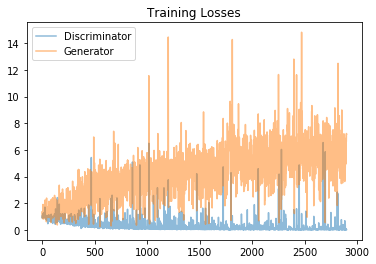

In [46]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [47]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [48]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

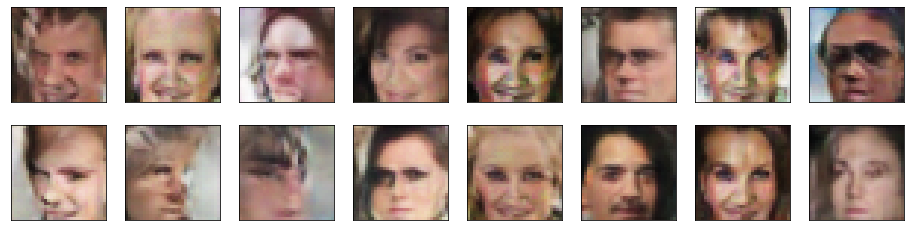

In [49]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 
To increase final result we could use bigger dataset, faces from different cultures, augumentation tecnics (pivot, center crop, etc.) The dipper model also should increase result, but it require more epochs. 

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.